# 04 – Backtesting and Performance Evaluation

This notebook evaluates the performance of the momentum strategies built in previous steps. It computes portfolio returns, backtests different configurations (long-only and long-short), and analyzes key risk-adjusted metrics, including Sharpe, Sortino, Calmar, and maximum drawdown.  

The results are then compared to the **SPY benchmark** and adjusted for **transaction costs** to assess real-world feasibility.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from math import *

## 1. Load Processed Data and Portfolio Weights
We import the monthly returns and precomputed portfolio weights from the previous notebook.  
This ensures a consistent, reproducible pipeline between signal generation and performance evaluation.

In [29]:
monthly_returns = pd.read_csv("data/processed/sp500_20_returns.csv", index_col=0, parse_dates=True)

momentum_signal = pd.read_csv("data/processed/momentum_signal_static.csv", index_col=0, parse_dates=True)
weights_long_only = pd.read_csv("data/processed/weights_long_only_static.csv", index_col=0, parse_dates=True)
weights_long_short = pd.read_csv("data/processed/weights_long_short_static.csv", index_col=0, parse_dates=True)
weights_holding   = pd.read_csv("data/processed/weights_holding_static.csv", index_col=0, parse_dates=True)

common_dates = monthly_returns.index.intersection(weights_holding.index)
common_cols   = monthly_returns.columns.intersection(weights_holding.columns)
monthly_returns = monthly_returns.loc[common_dates, common_cols]
weights_long_only = weights_long_only.loc[common_dates, common_cols]
weights_long_short = weights_long_short.loc[common_dates, common_cols]
weights_holding = weights_holding.loc[common_dates, common_cols]

## 2. Avoid Look-Ahead Bias
Portfolio weights are lagged by one period (`shift(1)`) to ensure that signals generated at time *t* are applied to returns realized in *t + 1*.  
This step prevents look-ahead bias and guarantees realistic backtesting results.

In [30]:
# Effective weights used for realized returns
w_lo_1m   = weights_long_only.shift(1)      # long-only, 1-month holding
w_ls_1m   = weights_long_short.shift(1)     # long-short, 1-month holding
w_ls_hold = weights_holding.shift(1)        # long-short with 3-month overlapping holding

## 3. Compute Portfolio Returns
We calculate the realized monthly returns for each strategy:

- **Long-Only (1M):** invests only in top-ranked winners.  
- **Long-Short (1M):** buys winners and shorts losers each month (market-neutral).  
- **Long-Short (3M holding):** applies a 3-month overlapping holding structure.  

In [31]:
# Strategy monthly returns
ret_lo_1m   = (w_lo_1m   * monthly_returns).sum(axis=1)         # long-only
ret_ls_1m   = (w_ls_1m   * monthly_returns).sum(axis=1)         # long-short (no overlap)
ret_ls_hold = (w_ls_hold * monthly_returns).sum(axis=1)         # long-short (3-month holding)

spy = yf.download(
    "SPY",
    start=str(monthly_returns.index.min().date()),
    end=str(monthly_returns.index.max().date()),
    auto_adjust=True
)["Close"]

spy_m = spy.resample("ME").last().pct_change().dropna()
spy_m = spy_m.reindex(ret_ls_hold.index).ffill().squeeze()

[*********************100%***********************]  1 of 1 completed


## 4. Performance Metrics
We evaluate each strategy using key performance indicators:

| Metric | Description |
|--------|--------------|
| **CAGR** | Compound Annual Growth Rate |
| **Ann.Vol** | Annualized volatility |
| **Sharpe Ratio** | Risk-adjusted return (total volatility) |
| **Sortino Ratio** | Risk-adjusted return (downside volatility) |
| **Max Drawdown** | Largest cumulative loss from a peak |
| **Calmar Ratio** | Return-to-drawdown efficiency |

These metrics provide a complete view of profitability, stability, and risk efficiency.

In [32]:
def cagr(r):
    r = r.dropna()
    if r.empty: return np.nan
    n_years = (r.index[-1] - r.index[0]).days / 365.25
    return (np.prod(1 + r) ** (1 / n_years)) - 1

def ann_vol(r): 
    return r.std() * sqrt(12)

def sharpe(r, rf=0.0):
    # rf monthly assumed 0 for simplicity
    mu = r.mean()
    sig = r.std()
    return np.nan if sig == 0 else (mu / sig) * sqrt(12)

def sortino(r, rf=0.0):
    ex = r - rf/12
    downside = ex[ex < 0]
    ds = downside.std()
    return np.nan if ds == 0 else (ex.mean() / ds) * sqrt(12)

def max_drawdown(r):
    eq = (1 + r).cumprod()
    peak = eq.cummax()
    dd = (eq / peak) - 1
    return dd.min()

def calmar(r):
    md = abs(max_drawdown(r))
    return np.nan if md == 0 else cagr(r) / md

def summarize(name, r):
    return pd.Series({
        "CAGR": cagr(r),
        "Ann.Vol": ann_vol(r),
        "Sharpe": sharpe(r),
        "Sortino": sortino(r),
        "MaxDD": max_drawdown(r),
        "Calmar": calmar(r)
    }, name=name)

perf = pd.concat([
    summarize("Long-Only (1M)",   ret_lo_1m),
    summarize("Long-Short (1M)",  ret_ls_1m),
    summarize("Long-Short (3M holding)", ret_ls_hold),
    summarize("SPY",               spy_m)
], axis=1).T

perf.round(4)

,CAGR,Ann.Vol,Sharpe,Sortino,MaxDD,Calmar
Long-Only (1M),0.1368,0.1785,0.8085,1.2671,-0.4550,0.3007
Long-Short (1M),-0.0254,0.2424,0.0194,0.0263,-0.7160,-0.0354
Long-Short (3M holding),-0.0201,0.2234,0.0247,0.0334,-0.7039,-0.0285
SPY,0.0872,0.1501,0.6329,0.8676,-0.5078,0.1718


## 5. Equity Curves
The chart below compares cumulative growth for all strategies versus **SPY**. It illustrates the compounding effect of each portfolio and highlights the performance gap between the long-only and market-neutral configurations.

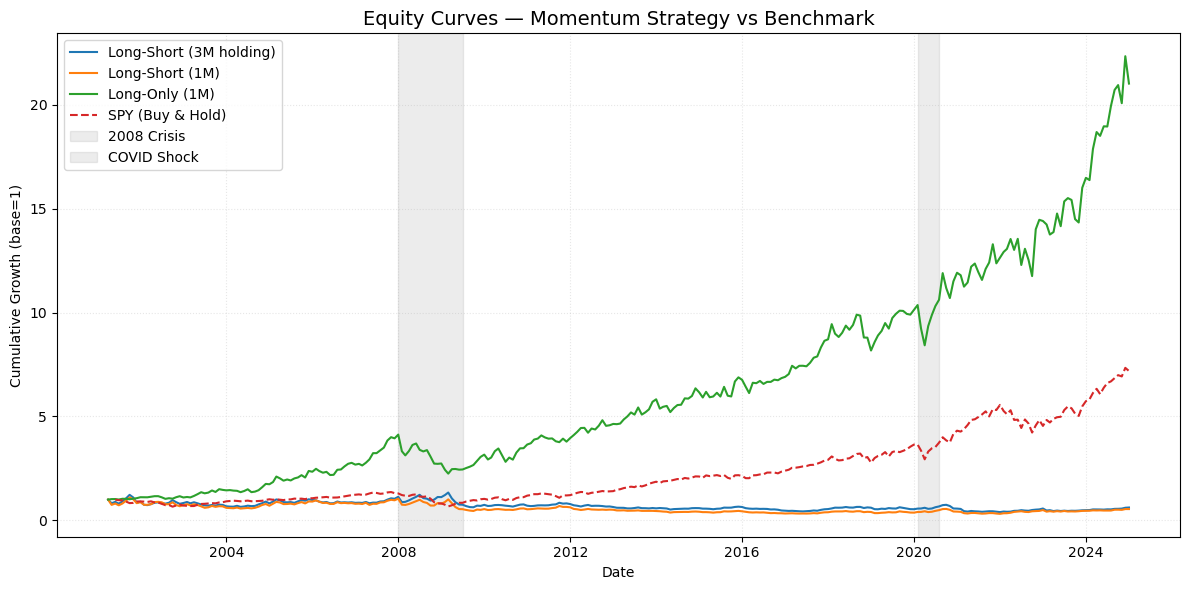

In [33]:
eq_lo   = (1 + ret_lo_1m).cumprod()
eq_ls1  = (1 + ret_ls_1m).cumprod()
eq_lsh  = (1 + ret_ls_hold).cumprod()
eq_spy  = (1 + spy_m).cumprod()

plt.figure(figsize=(12,6))
plt.plot(eq_lsh, label="Long-Short (3M holding)")
plt.plot(eq_ls1, label="Long-Short (1M)")
plt.plot(eq_lo,  label="Long-Only (1M)")
plt.plot(eq_spy, label="SPY (Buy & Hold)", linestyle="--")
plt.title("Equity Curves — Momentum Strategy vs Benchmark", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Cumulative Growth (base=1)")
plt.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-30"), color="gray", alpha=0.15, label="2008 Crisis")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-07-31"), color="gray", alpha=0.15, label="COVID Shock")
plt.legend(); plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout(); plt.show()

## 6. Drawdown Analysis
The following plot shows the historical drawdowns for each strategy.  
Drawdowns reveal periods of significant underperformance and help identify the risk profile of each approach.

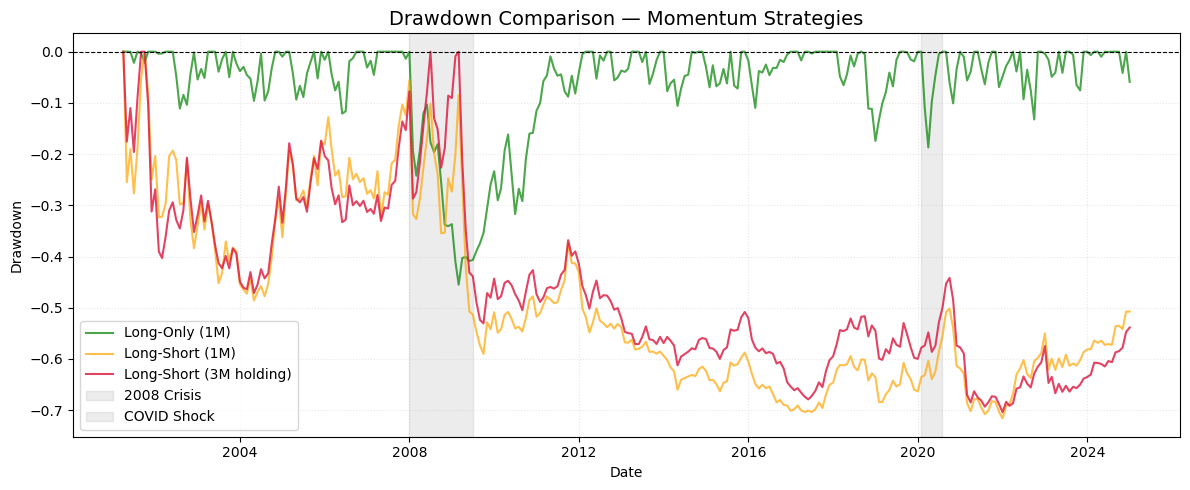

In [34]:
def drawdown_series(r):
    eq = (1 + r).cumprod()
    peak = eq.cummax()
    return (eq / peak) - 1

# Compute drawdowns for all three strategies
dd_lo   = drawdown_series(ret_lo_1m)
dd_ls1  = drawdown_series(ret_ls_1m)
dd_lsh  = drawdown_series(ret_ls_hold)

# Plot all together
plt.figure(figsize=(12,5))
plt.plot(dd_lo,  label="Long-Only (1M)", color="green", alpha=0.7)
plt.plot(dd_ls1, label="Long-Short (1M)", color="orange", alpha=0.7)
plt.plot(dd_lsh, label="Long-Short (3M holding)", color="crimson", alpha=0.8)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)

plt.title("Drawdown Comparison — Momentum Strategies", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-30"), color="gray", alpha=0.15, label="2008 Crisis")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-07-31"), color="gray", alpha=0.15, label="COVID Shock")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

## 7. Rolling Sharpe Ratio (12-Month Window)
We compute and plot the rolling Sharpe ratio over a 12-month window to capture the time-varying nature of risk-adjusted returns.  
Momentum strategies typically exhibit cyclical behavior,  with strong performance during trending markets and weaker results in mean-reverting regimes.

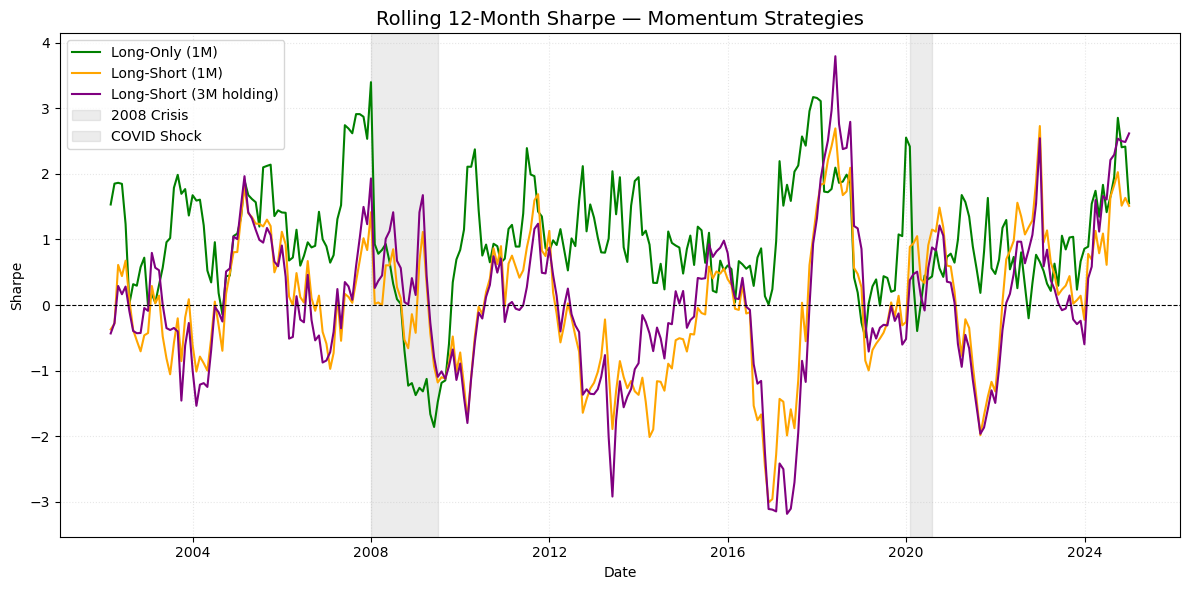

In [35]:
win = 12  # 12 months rolling window

def rolling_sharpe(r, window=12):
    return r.rolling(window).apply(lambda x: np.mean(x)/np.std(x) if np.std(x)>0 else np.nan) * np.sqrt(12)

roll_sharpe_lo  = rolling_sharpe(ret_lo_1m, win)
roll_sharpe_ls1 = rolling_sharpe(ret_ls_1m, win)
roll_sharpe_lsh = rolling_sharpe(ret_ls_hold, win)

# Plot
plt.figure(figsize=(12,6))
plt.plot(roll_sharpe_lo,  color='green', label='Long-Only (1M)')
plt.plot(roll_sharpe_ls1, color='orange', label='Long-Short (1M)')
plt.plot(roll_sharpe_lsh, color='purple', label='Long-Short (3M holding)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title("Rolling 12-Month Sharpe — Momentum Strategies", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Sharpe")
plt.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-30"), color="gray", alpha=0.15, label="2008 Crisis")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-07-31"), color="gray", alpha=0.15, label="COVID Shock")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

In [36]:
print(f"Average Rolling Sharpe (Long-Only): {roll_sharpe_lo.mean():.2f}")
print(f"Average Rolling Sharpe (Long-Short 1M): {roll_sharpe_ls1.mean():.2f}")
print(f"Average Rolling Sharpe (Long-Short 3M): {roll_sharpe_lsh.mean():.2f}")

Average Rolling Sharpe (Long-Only): 0.99
Average Rolling Sharpe (Long-Short 1M): 0.02
Average Rolling Sharpe (Long-Short 3M): 0.03


## 8. Portfolio Turnover Analysis 
Portfolio turnover measures how much the portfolio composition changes from one month to the next. High turnover indicates frequent rebalancing, which increases transaction costs and execution risk.

The chart below shows the **absolute monthly weight changes** for the Long-Only (1M) strategy. The orange dashed line represents the average turnover over the full sample period.

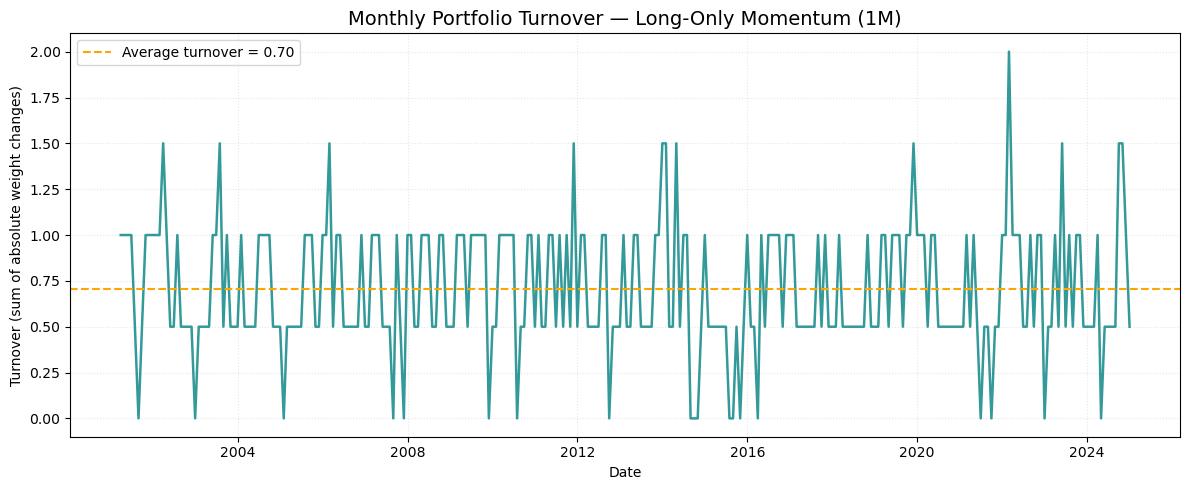

In [37]:
# Monthly portfolio turnover (absolute weight change)
turnover_lo = (weights_long_only.fillna(0) - 
               weights_long_only.shift(1).fillna(0)).abs().sum(axis=1)

plt.figure(figsize=(12,5))
plt.plot(turnover_lo, color='teal', lw=1.8, alpha=0.8)
plt.axhline(turnover_lo.mean(), color='orange', linestyle='--', lw=1.5,
            label=f"Average turnover = {turnover_lo.mean():.2f}")
plt.title("Monthly Portfolio Turnover — Long-Only Momentum (1M)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Turnover (sum of absolute weight changes)")
plt.grid(alpha=0.3, linestyle=":")
plt.legend()
plt.tight_layout()
plt.show()


## 9. Transaction Costs and Turnover Impact
To make the analysis more realistic, we estimate the **monthly portfolio turnover** and apply transaction costs (5 basis points per side).  
We then compare gross and net performance to assess the frictional impact of trading.

In [38]:
cost_per_side = 0.0005        # 5 bps per side (0.05%)
costs_lo = turnover_lo * (2 * cost_per_side)   # buy + sell sides

# Net returns after costs
ret_lo_1m_net = ret_lo_1m - costs_lo

### Impact on Equity Curve
The figure below compares cumulative returns before and after costs. Even with moderate trading frictions, the long-only momentum portfolio maintains a strong growth trajectory, demonstrating strategy robustness.

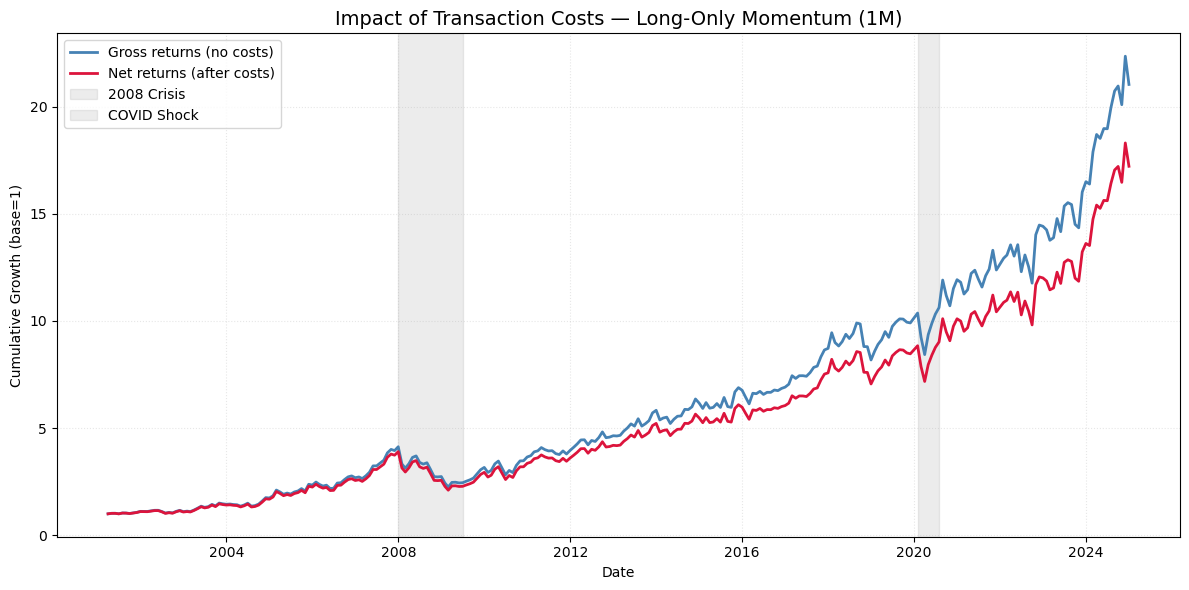

In [39]:
eq_lo_gross = (1 + ret_lo_1m).cumprod()
eq_lo_net   = (1 + ret_lo_1m_net).cumprod()

plt.figure(figsize=(12,6))
plt.plot(eq_lo_gross, label="Gross returns (no costs)", color="steelblue", lw=2)
plt.plot(eq_lo_net,   label="Net returns (after costs)", color="crimson", lw=2)
plt.title("Impact of Transaction Costs — Long-Only Momentum (1M)", fontsize=14)
plt.xlabel("Date"); plt.ylabel("Cumulative Growth (base=1)")
plt.axvspan(pd.Timestamp("2008-01-01"), pd.Timestamp("2009-06-30"), color="gray", alpha=0.15, label="2008 Crisis")
plt.axvspan(pd.Timestamp("2020-02-01"), pd.Timestamp("2020-07-31"), color="gray", alpha=0.15, label="COVID Shock")
plt.legend()
plt.grid(alpha=0.3, linestyle=":")
plt.tight_layout()
plt.show()

In [40]:
perf_costs_lo = pd.concat([
    summarize("Long-Only (1M, Gross)", ret_lo_1m),
    summarize("Long-Only (1M, Net 5 bps)", ret_lo_1m_net)
], axis=1).T

perf_costs_lo.round(4)


,CAGR,Ann.Vol,Sharpe,Sortino,MaxDD,Calmar
"Long-Only (1M, Gross)",0.1368,0.1785,0.8085,1.2671,-0.4550,0.3007
"Long-Only (1M, Net 5 bps)",0.1273,0.1786,0.7606,1.1825,-0.4611,0.2760


In [41]:
cost_levels = [0.0002, 0.0005, 0.001, 0.002]  # 2 bps, 5 bps, 10 bps, 20bps
results = []

for c in cost_levels:
    ret_net = ret_lo_1m - turnover_lo * (2 * c)
    results.append(summarize(f"Net ({c*10000:.0f} bps)", ret_net))

pd.concat(results, axis=1).T.round(4)

,CAGR,Ann.Vol,Sharpe,Sortino,MaxDD,Calmar
Net (2 bps),0.1330,0.1786,0.7893,1.2341,-0.4575,0.2907
Net (5 bps),0.1273,0.1786,0.7606,1.1825,-0.4611,0.2760
Net (10 bps),0.1178,0.1788,0.7126,1.1033,-0.4670,0.2522
Net (20 bps),0.0991,0.1791,0.6170,0.9463,-0.4788,0.2069


## Summary and Insights

- The **Long-Only (1M)** momentum strategy delivers strong performance (CAGR ≈ 13.7%, Sharpe ≈ 0.8),  
  outperforming the **SPY benchmark** on both absolute and risk-adjusted bases.  
- The **Long-Short** versions exhibit higher volatility and deeper drawdowns, consistent with known momentum crash behavior.  
- Transaction costs slightly reduce performance but do not eliminate the long-only momentum premium.  

Overall, the results confirm that **medium-term cross-sectional momentum** remains a persistent and exploitable source of excess return.